# Lecture : Recommendation on Graphs

## Lab 03 : Content recommendation

### Xavier Bresson  


In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/GML2023_codes/codes/05_Recommendation'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    

In [2]:
# Load libraries
import numpy as np
import scipy.io
%matplotlib inline
#%matplotlib notebook 
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import time
import sys; sys.path.insert(0, 'lib/')
from lib.utils import shrink
from lib.utils import graph_laplacian
import scipy.sparse.linalg
import warnings; warnings.filterwarnings("ignore")
from lib.utils import compute_ncut, reindex_W_with_classes, construct_knn_graph
import torch
import networkx as nx


# Synthetic dataset

In [7]:
# Load graphs of rows/users and columns/movies
mat = scipy.io.loadmat('datasets/synthetic_netflix.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining) / (n*m)
print('perc_obs_training=',perc_obs_training)


n,m= 150 200
perc_obs_training= 0.03


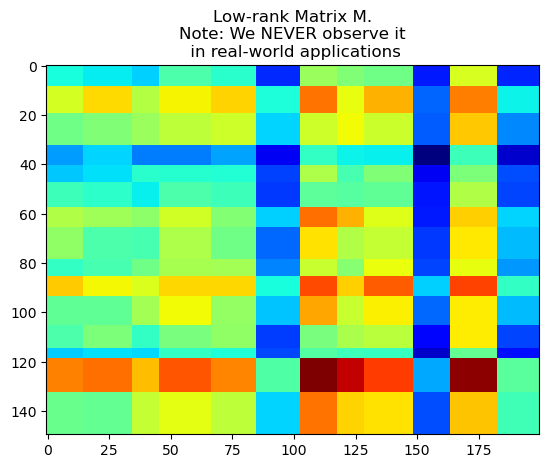

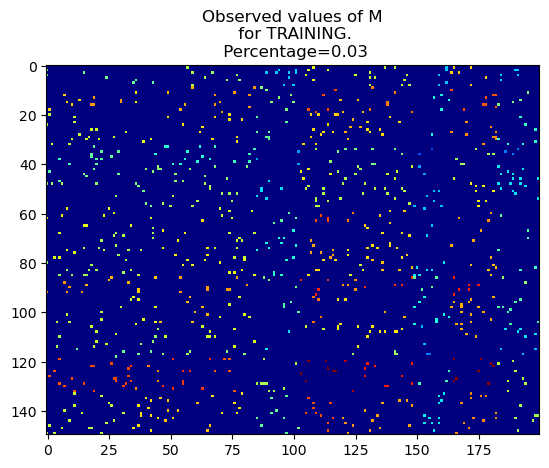

In [8]:
# Viusalize the rating matrix
plt.figure(1)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Low-rank Matrix M.\nNote: We NEVER observe it\n in real-world applications')
plt.show()

plt.figure(2)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M\n for TRAINING.\n Percentage=' + str(perc_obs_training))
plt.show()


Reconstruction Error: 161.32328


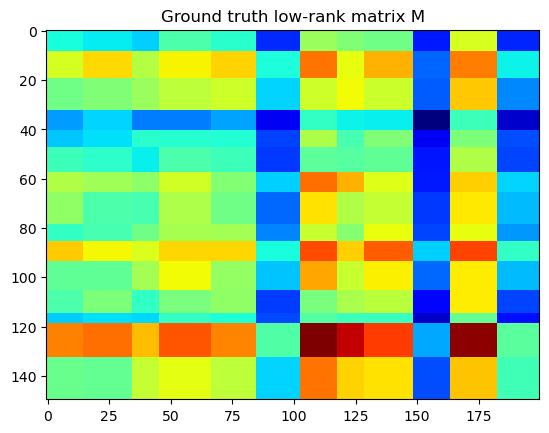

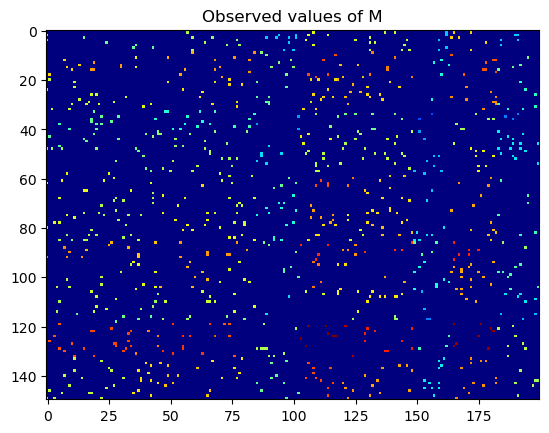

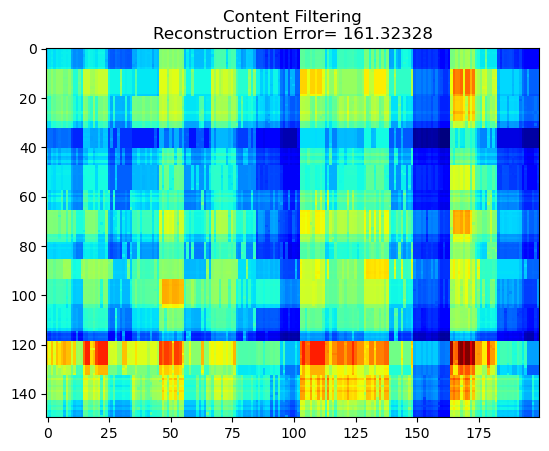

In [9]:
# Content Filtering / Graph Regularization by Dirichlet Energy

#######################################
# Select the set of hyper-parameters
#######################################

# scenario : very low number of ratings, 0.03%, error metric = 161.32
lambdaDir = 1e-1; lambdaDF = 1e3; alpha = 0.02


# Compute Graph Laplacians
Lr = graph_laplacian(Wrow)
Lc = graph_laplacian(Wcol)
I = scipy.sparse.identity(m, dtype=Lr.dtype)
Lr = scipy.sparse.kron( I, Lr )
Lr = scipy.sparse.csr_matrix(Lr)
I = scipy.sparse.identity(n, dtype=Lc.dtype)
Lc = scipy.sparse.kron( Lc, I )
Lc = scipy.sparse.csr_matrix(Lc)

# Pre-processing
L = alpha* Lc + (1.-alpha)* Lr 
vecO = np.reshape(O.T,[-1]) 
vecO = scipy.sparse.diags(vecO, 0, shape=(n*m, n*m) ,dtype=L.dtype)
vecO = scipy.sparse.csr_matrix(vecO) 
At = lambdaDir* L + lambdaDF* vecO 
vecM = np.reshape(M.T,[-1])
bt = lambdaDF* scipy.sparse.csr_matrix( vecM ).T
bt = np.array(bt.todense()).squeeze()

# Solve by linear system
x,_ = scipy.sparse.linalg.cg(At, bt, x0=bt, tol=1e-9, maxiter=100)
X = np.reshape(x,[m,n]).T
 
# Reconstruction error
err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)
print('Reconstruction Error: '+ str(round(err_test,5)))

# Plot
plt.figure(2)
plt.imshow(Mgt, interpolation='nearest', cmap='jet')
plt.title('Ground truth low-rank matrix M')

plt.figure(3)
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet')
plt.title('Observed values of M')

plt.figure(4)
plt.imshow(X, interpolation='nearest', cmap='jet')
plt.title('Content Filtering\nReconstruction Error= '+ str(round(err_test,5)))
plt.show()


# Real-world dataset SWEETRS

In [26]:
# Load graphs of rows/users and columns/products
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario1.mat')
mat = scipy.io.loadmat('datasets/real_sweetrs_scenario2.mat')
# mat = scipy.io.loadmat('datasets/real_sweetrs_scenario3.mat')
M = mat['M']
Otraining = mat['Otraining']
Otest = mat['Otest']
Wrow = mat['Wrow']
Wcol = mat['Wcol']
print('M', M.shape)
print('Otraining', Otraining.shape)
print('Otest', Otest.shape)
print('Wrow', Wrow.shape)
print('Wcol', Wcol.shape)

n,m = M.shape
print('n,m=',n,m)

Mgt = M # Ground truth
O = Otraining
M = O* Mgt
perc_obs_training = np.sum(Otraining)/(n*m)
print('perc_obs_training=',perc_obs_training)
perc_obs_test = np.sum(Otest) / (n*m)


M (664, 77)
Otraining (664, 77)
Otest (664, 77)
Wrow (664, 664)
Wcol (77, 77)
n,m= 664 77
perc_obs_training= 0.1317868878109842


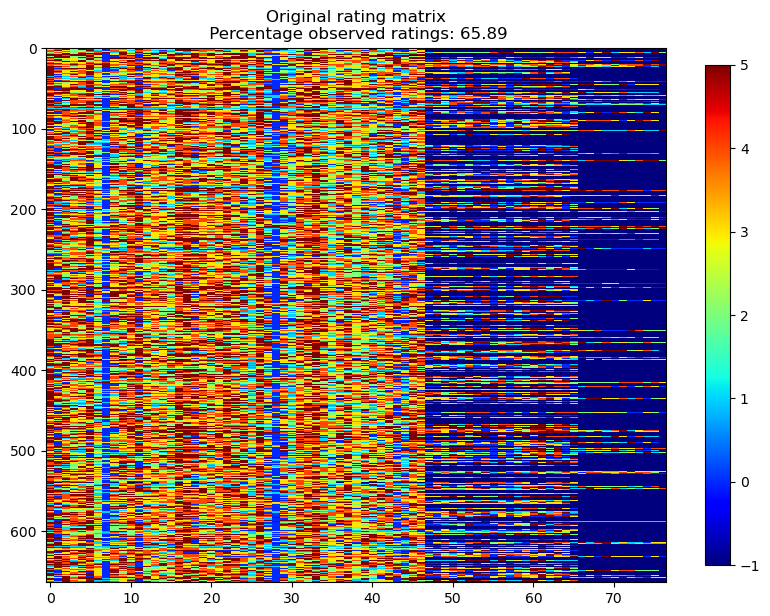

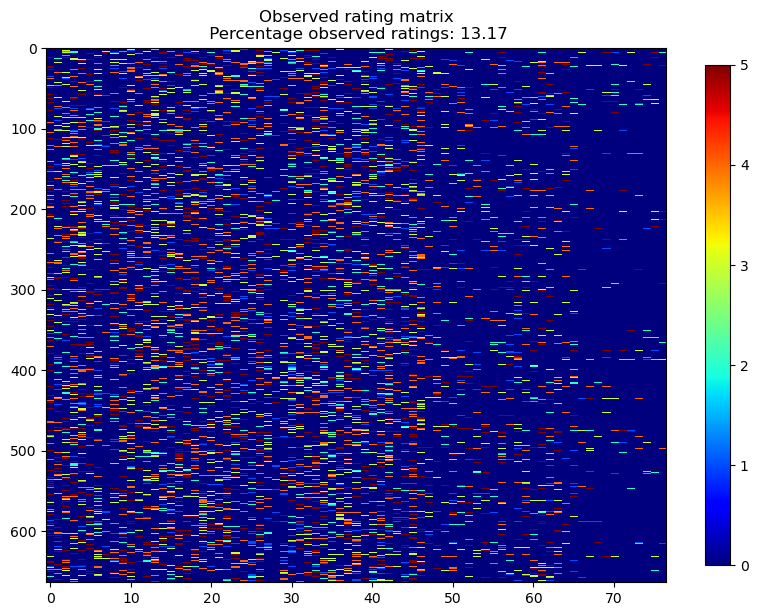

In [27]:
# Visualize the original rating matrix
plt.figure(1,figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])

# Visualize the observed rating matrix
plt.figure(2, figsize=(10,10))
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.show()


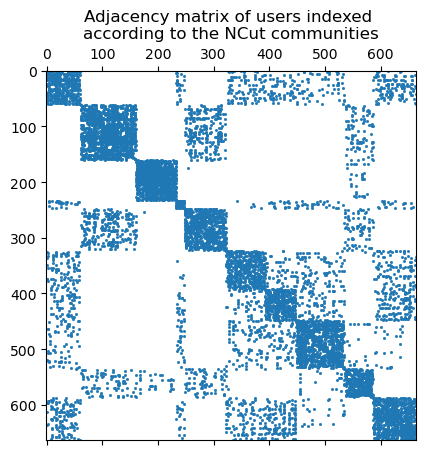

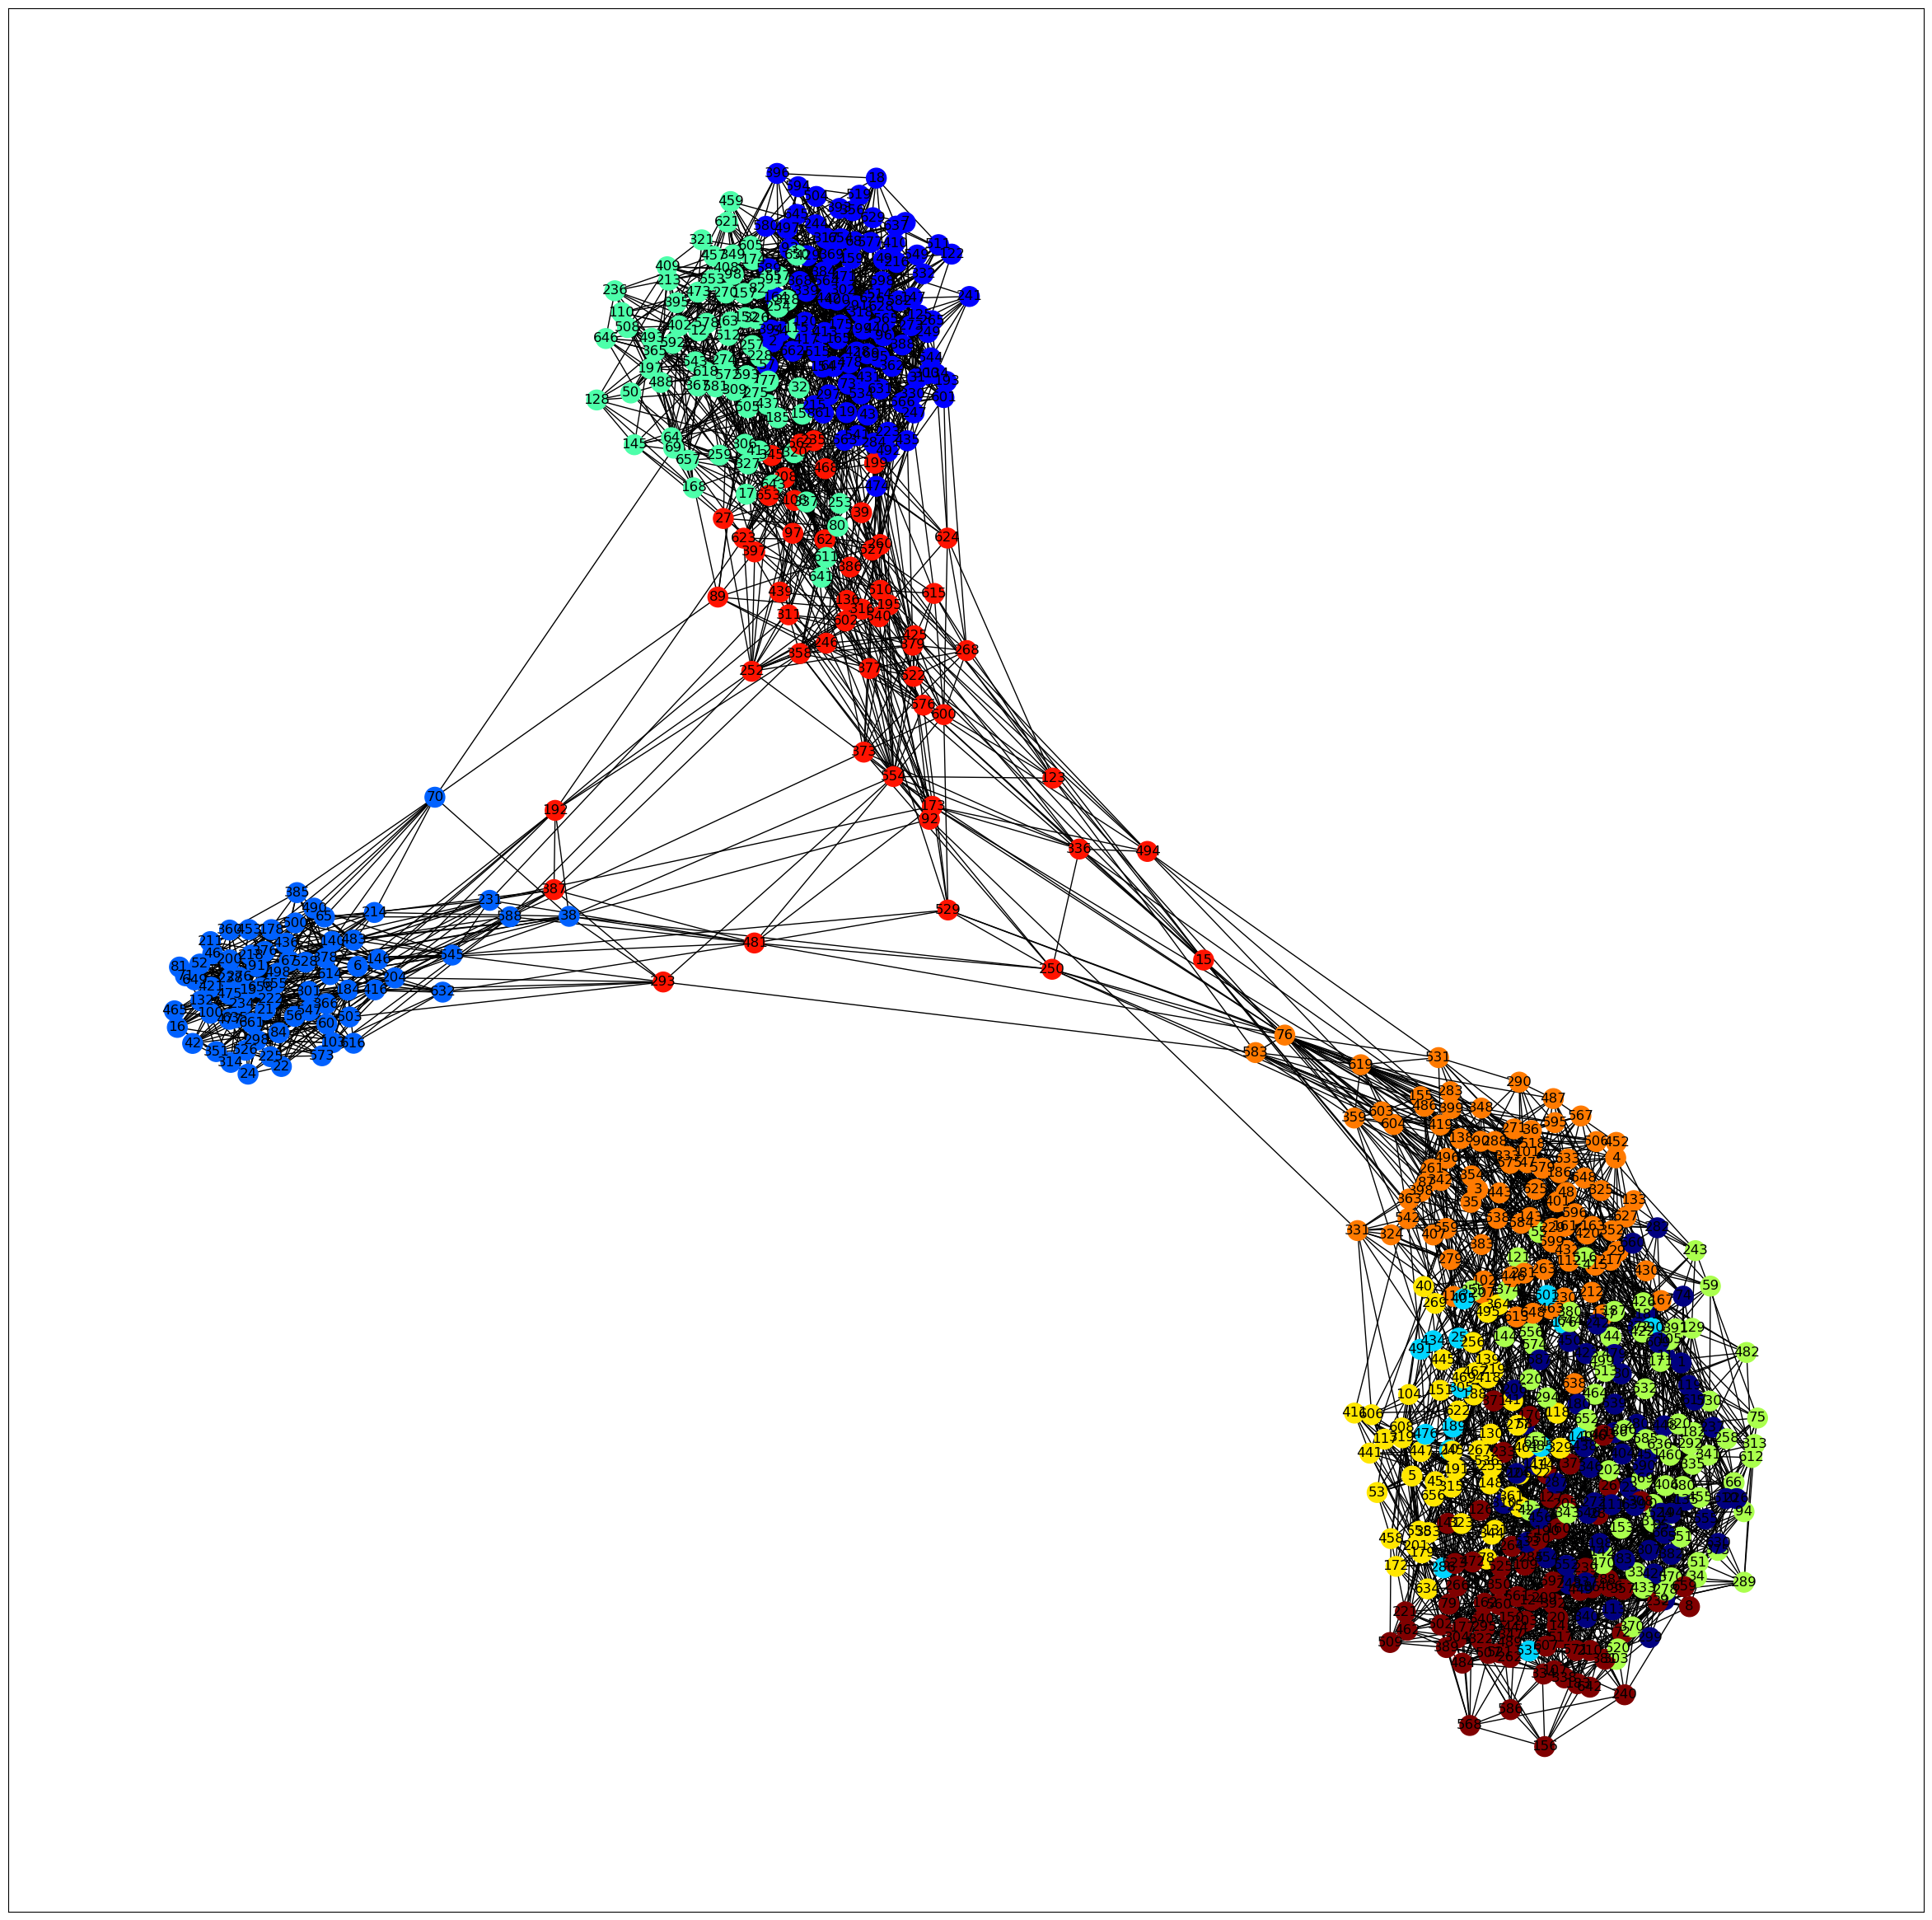

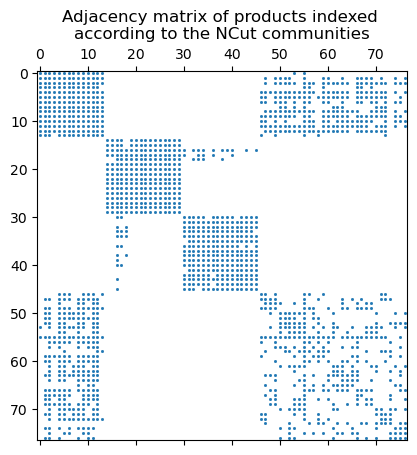

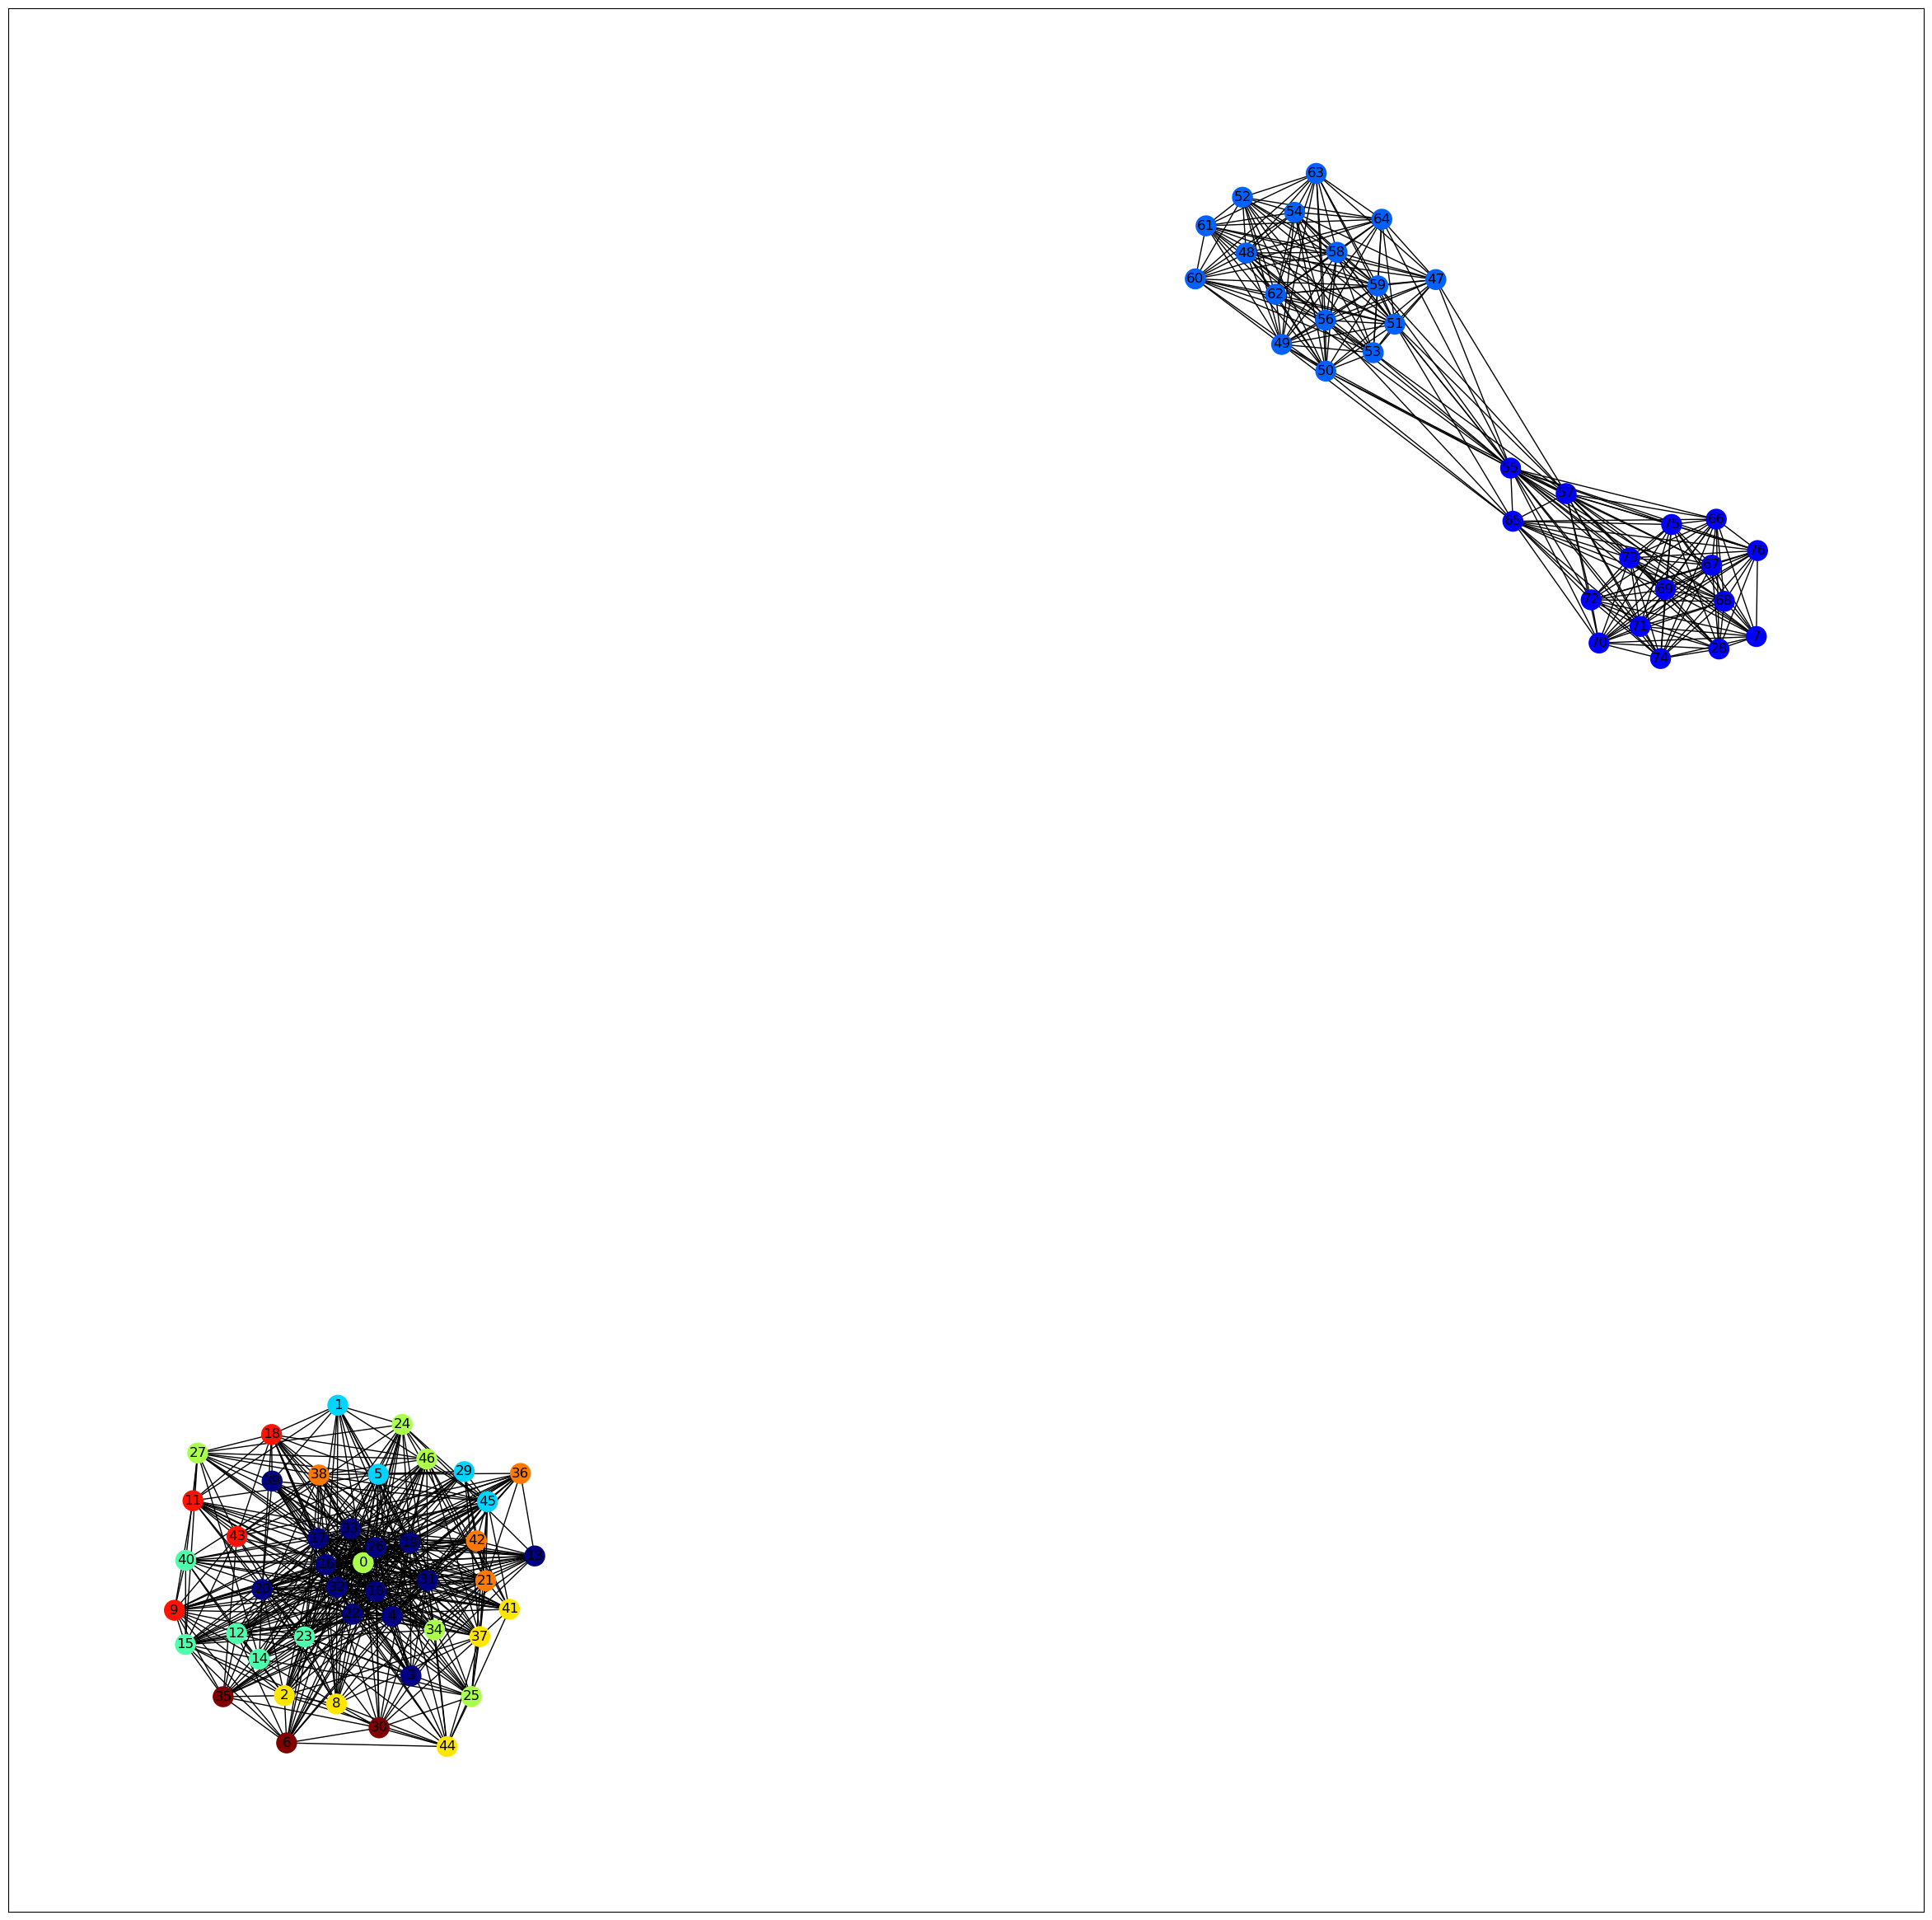

In [28]:
# Visualize graph of users and graph of products
 # Plot adjacency matrix w.r.t. NCut communities

# plot graph of users
W = Wrow
nc = 10; Cncut, _ = compute_ncut(W, np.zeros(Mgt.shape[0]), nc)# compute NCut clustering 
[reindexed_W_ncut,reindexed_C_ncut] = reindex_W_with_classes(W,Cncut)
plt.figure(1)
plt.spy(reindexed_W_ncut, precision=0.01, markersize=1)
plt.title('Adjacency matrix of users indexed \naccording to the NCut communities')
plt.show()
A = W.copy()
A.setdiag(0) 
A.eliminate_zeros()
G_nx = nx.from_scipy_sparse_array(A)
plt.figure(2,figsize=[30,30])
nx.draw_networkx(G_nx, with_labels=True, node_color=np.array(Cncut), cmap='jet')

# plot graph of products
W = Wcol
nc = 10; Cncut, _ = compute_ncut(W, np.zeros(Mgt.shape[1]), nc)# compute NCut clustering 
[reindexed_W_ncut,reindexed_C_ncut] = reindex_W_with_classes(W,Cncut)
plt.figure(3)
plt.spy(reindexed_W_ncut, precision=0.01, markersize=1)
plt.title('Adjacency matrix of products indexed \naccording to the NCut communities')
plt.show()
A = W.copy()
A.setdiag(0) 
A.eliminate_zeros()
G_nx = nx.from_scipy_sparse_array(A)
plt.figure(4,figsize=[30,30])
nx.draw_networkx(G_nx, with_labels=True, node_color=np.array(Cncut), cmap='jet')



Reconstruction Error: 411.24489


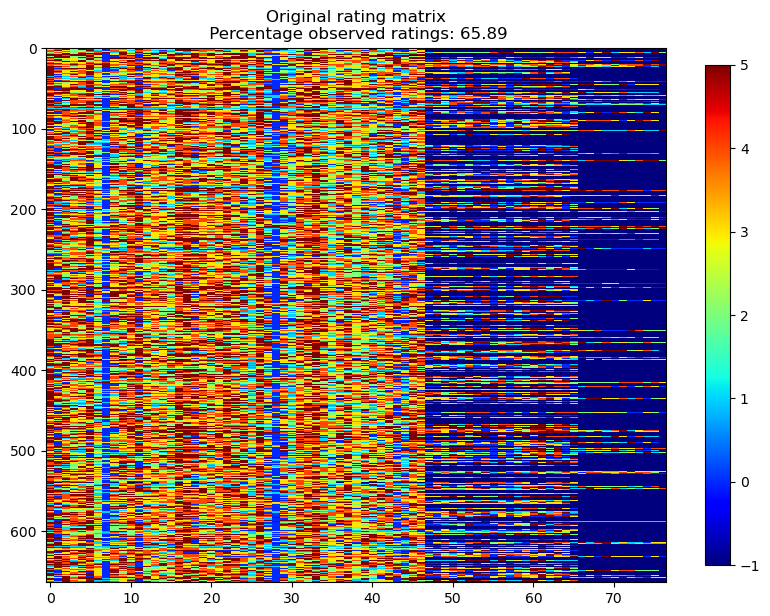

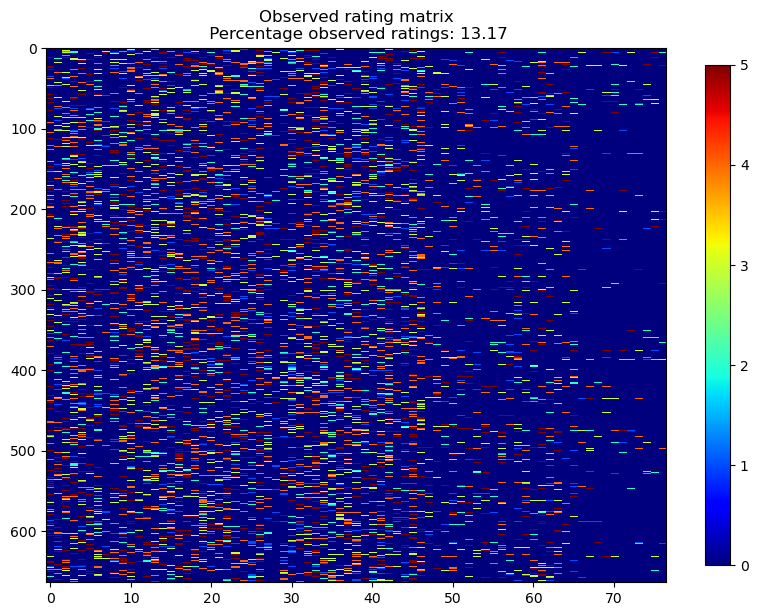

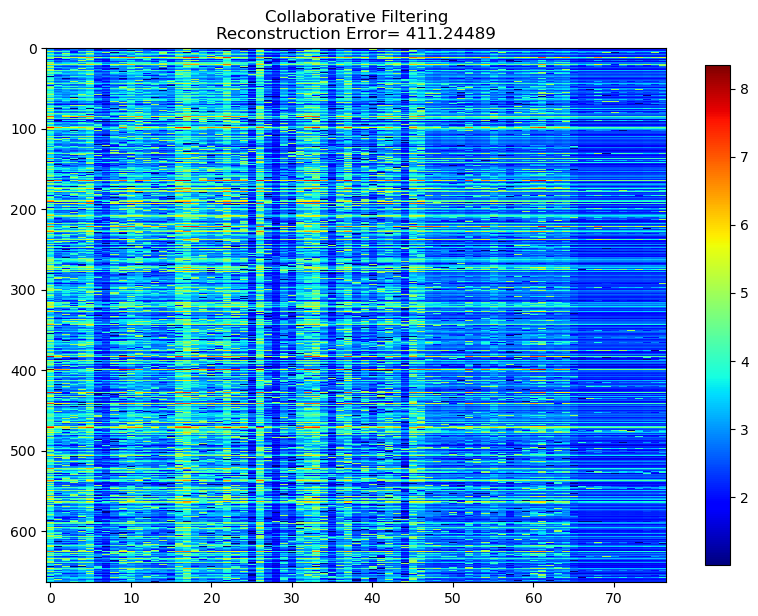

In [29]:
# Content Filtering / Graph Regularization by Dirichlet Energy

#######################################
# Select the set of hyper-parameters
#######################################

# scenario 1 : low number of ratings, e.g. 1.3%, error metric = 399.89
lambdaDir = 1e-1; lambdaDF = 1e3; alpha = 0.02

# scenario 2 : intermediate number of ratings, e.g. 13.1%, error metric = 411.24
lambdaDir = 1e-1; lambdaDF = 1e3; alpha = 0.02

# scenario 3 : large number of ratings, e.g. 52.7%, error metric = 748.52
# lambdaDir = 1e-1; lambdaDF = 1e3; alpha = 0.02


# Compute Graph Laplacians
Lr = graph_laplacian(Wrow)
Lc = graph_laplacian(Wcol)
I = scipy.sparse.identity(m, dtype=Lr.dtype)
Lr = scipy.sparse.kron( I, Lr )
Lr = scipy.sparse.csr_matrix(Lr)
I = scipy.sparse.identity(n, dtype=Lc.dtype)
Lc = scipy.sparse.kron( Lc, I )
Lc = scipy.sparse.csr_matrix(Lc)

# Pre-processing
L = alpha* Lc + (1.-alpha)* Lr 
vecO = np.reshape(O.T,[-1]) 
vecO = scipy.sparse.diags(vecO, 0, shape=(n*m, n*m) ,dtype=L.dtype)
vecO = scipy.sparse.csr_matrix(vecO) 
At = lambdaDir* L + lambdaDF* vecO 
vecM = np.reshape(M.T,[-1])
bt = lambdaDF* scipy.sparse.csr_matrix( vecM ).T
bt = np.array(bt.todense()).squeeze()

# Solve by linear system
x,_ = scipy.sparse.linalg.cg(At, bt, x0=bt, tol=1e-9, maxiter=100)
X = np.reshape(x,[m,n]).T
 
# Reconstruction error
err_test = np.sqrt(np.sum((Otest*(X-Mgt))**2)) / np.sum(Otest) * (n*m)
print('Reconstruction Error: '+ str(round(err_test,5)))

# Plots
plt.figure(2, figsize=(10,10))
plt.imshow(Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Original rating matrix\n Percentage observed ratings: ' + str(100*np.sum(Mgt>0)/(n*m))[:5])
plt.show()

plt.figure(3, figsize=(10,10))
plt.imshow(Otraining*Mgt, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Observed rating matrix\n Percentage observed ratings: ' + str(100*perc_obs_training)[:5])
plt.show()

plt.figure(4, figsize=(10,10))
plt.imshow(X, interpolation='nearest', cmap='jet', aspect=0.1)
plt.colorbar(shrink=0.65)
plt.title('Collaborative Filtering\nReconstruction Error= '+ str(round(err_test,5)))
plt.show()
